In [304]:
import pandas as pd
import prisma_ml as prisma
import numpy as np
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    QuantileTransformer,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import classification_report, roc_auc_score
import mlflow
import mlflow.sklearn
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time

In [305]:
df = pd.read_csv(r"../../data/processed/emotet_static.csv")

## EDA

In [306]:
info = prisma.DatasetInformation(df)

df.drop_duplicates(inplace=True)

info.dataframe_summary()

### Shape:

(79644, 31)

### Columns and Metadata:

,Data Type,Null Values,Percentage of Nulls
Duration,float64,0,0.0
Source Port,int64,0,0.0
Destination Port,int64,0,0.0
Protocol,object,0,0.0
Flags,object,0,0.0
Packets,int64,0,0.0
Bytes,int64,0,0.0
Mean Payload Size,float64,0,0.0
Std Payload Size,float64,0,0.0
Min Payload Size,int64,0,0.0


### Duplicated Rows:

,Duplicated Rows Count
Total,0


### Categorical

In [307]:
info = prisma.DatasetInformation(df)

info.categorical_summary()

### Categorical Columns Summary:

,Column,Unique Values Count,Top Value,Top Value Percentage
0,Protocol,4,TCP,76.17%
1,Flags,14,SYN,51.50%
2,Label,2,Benign,53.87%
3,Direction,1,outbound,100.00%


### Column: Protocol

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,TCP,60661,76.165185
1,HTTP,14216,17.849430
2,DATA-TEXT-LINES,4743,5.955251
3,XML,24,0.030134


---

### Column: Flags

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,SYN,41013,51.495405
1,"PSH,ACK",18926,23.763246
2,"FIN,SYN,ACK",9294,11.669429
3,"SYN,RST,ACK",6277,7.881322
4,"FIN,SYN,RST,ACK",2958,3.714027
5,"FIN,SYN,PSH,ACK",556,0.698107
6,"SYN,ACK",289,0.362865
7,"FIN,SYN,RST,PSH,ACK",119,0.149415
8,"SYN,RST",64,0.080358
9,"SYN,PSH,ACK",53,0.066546


---

### Column: Label

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,Benign,42907,53.873487
1,Emotet,36737,46.126513


---

### Column: Direction

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,outbound,79644,100.000000


---

### Numerical

### Numerical Columns Statistical Summary:

,Duration,Source Port,Destination Port,Packets,Bytes,Mean Payload Size,Std Payload Size,Min Payload Size,Max Payload Size,Mean Entropy,...,Bytes per Second,Destination Common Port Usage,Flags Count,SYN Count,ACK Count,FIN Count,Is HTTP,Is Internal IP,Short Duration,Single Packet
Mean,9.324392e+04,4.496880e+04,1.975890e+04,2.972791,2.635384e+02,134.160047,3.209447,131.291912,138.800663,0.823977,...,1.002451e+08,0.004734,1.774949,0.761627,0.484230,0.163038,0.178494,0.756780,0.256642,0.252197
Median,8.999836e+00,5.385800e+04,8.080000e+03,3.000000,1.340000e+02,44.666667,1.885618,42.000000,46.000000,0.000000,...,1.488923e+01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Mode,1.000000e-06,8.080000e+03,8.080000e+03,3.000000,1.340000e+02,44.666667,1.885618,42.000000,46.000000,0.000000,...,4.590000e+08,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Std Dev,3.967328e+05,2.154838e+04,2.080730e+04,3.517148,3.863091e+03,185.355004,19.519221,185.457367,187.853232,1.461305,...,1.992504e+08,0.068638,0.923231,0.426091,0.499754,0.369403,0.382931,0.429029,0.436783,0.434277
Variance,1.573969e+11,4.643327e+08,4.329435e+08,12.370328,1.492347e+07,34356.477610,381.000003,34394.434970,35288.836650,2.135413,...,3.970072e+16,0.004711,0.852356,0.181554,0.249754,0.136458,0.146636,0.184066,0.190779,0.188596
Range,3.037289e+06,6.545400e+04,6.545200e+04,397.000000,4.833180e+05,1344.000000,706.842104,1344.000000,1420.000000,3.584086,...,1.378000e+09,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Min,1.000000e-06,8.000000e+01,8.000000e+01,1.000000,3.400000e+01,34.000000,0.000000,34.000000,34.000000,0.000000,...,6.415428e-05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Max,3.037289e+06,6.553400e+04,6.553200e+04,398.000000,4.833520e+05,1378.000000,706.842104,1378.000000,1454.000000,3.584086,...,1.378000e+09,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Correlation Matrix:

,Duration,Source Port,Destination Port,Packets,Bytes,Mean Payload Size,Std Payload Size,Min Payload Size,Max Payload Size,Mean Entropy,...,Bytes per Second,Destination Common Port Usage,Flags Count,SYN Count,ACK Count,FIN Count,Is HTTP,Is Internal IP,Short Duration,Single Packet
Duration,1.000000,0.036656,-0.077455,0.215737,0.012088,-0.071166,0.006159,-0.072659,-0.070721,-0.073288,...,-0.118248,-0.016194,-0.011033,0.072997,-0.045082,0.001550,-0.046786,0.074734,-0.138099,-0.136490
Source Port,0.036656,1.000000,-0.971710,0.075416,-0.029278,-0.253926,-0.067450,-0.249421,-0.263452,-0.329408,...,-0.265340,0.022827,-0.545647,0.342077,-0.590318,-0.509738,-0.108899,0.977849,-0.319048,-0.309355
Destination Port,-0.077455,-0.971710,1.000000,-0.091396,0.025074,0.246048,0.042975,0.243441,0.251094,0.324167,...,0.260754,-0.065225,0.528078,-0.338595,0.579332,0.496987,0.114594,-0.991465,0.313469,0.307811
Packets,0.215737,0.075416,-0.091396,1.000000,0.870581,-0.207530,0.311905,-0.278339,-0.181475,-0.283075,...,-0.282201,0.046875,0.136151,0.310389,-0.043265,0.151314,-0.257784,0.089783,-0.321045,-0.325739
Bytes,0.012088,-0.029278,0.025074,0.870581,1.000000,0.109222,0.297064,0.031563,0.122994,0.052921,...,0.030312,0.002883,0.043942,-0.024472,0.033163,0.014032,0.013967,-0.024884,0.020120,0.020136
Mean Payload Size,-0.071166,-0.253926,0.246048,-0.207530,0.109222,1.000000,0.011387,0.993060,0.985390,0.880738,...,0.982910,-0.019744,0.114107,-0.876913,0.498055,-0.223283,0.591395,-0.248171,0.816688,0.825028
Std Payload Size,0.006159,-0.067450,0.042975,0.311905,0.297064,0.011387,1.000000,-0.081193,0.172124,-0.040309,...,-0.082722,0.305185,0.189466,0.087771,0.073311,0.137195,-0.075641,-0.052521,-0.065338,-0.095488
Min Payload Size,-0.072659,-0.249421,0.243441,-0.278339,0.031563,0.993060,-0.081193,1.000000,0.967360,0.882919,...,0.990148,-0.036076,0.103719,-0.884631,0.496187,-0.230728,0.598172,-0.245683,0.823433,0.833554
Max Payload Size,-0.070721,-0.263452,0.251094,-0.181475,0.122994,0.985390,0.172124,0.967360,1.000000,0.862812,...,0.957410,0.046190,0.152236,-0.851878,0.509846,-0.192476,0.572119,-0.255581,0.797360,0.799710
Mean Entropy,-0.073288,-0.329408,0.324167,-0.283075,0.052921,0.880738,-0.040309,0.882919,0.862812,1.000000,...,0.887093,-0.008624,0.149040,-0.995828,0.581941,-0.236616,0.839592,-0.327136,0.922596,0.931517


### Correlation Matrix Heatmap:

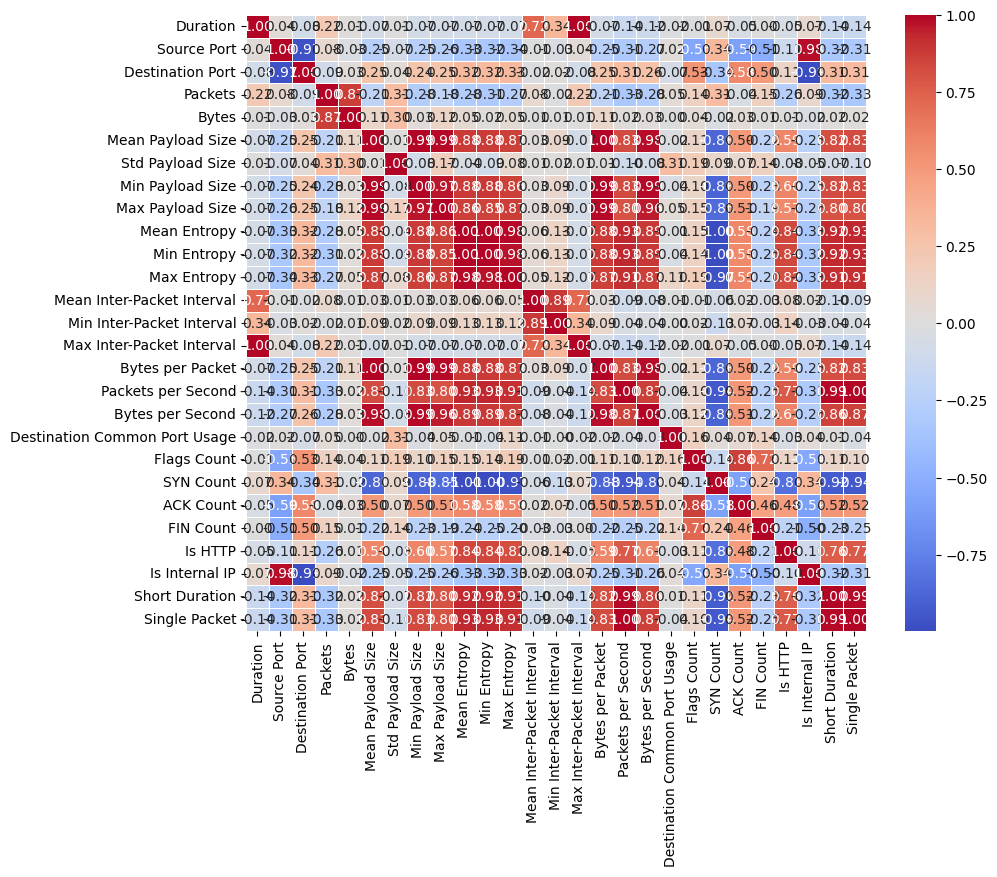

In [308]:
info.numerical_summary()

## Modeling

### Final Data Prep

In [309]:
def save_as_pickle(path, variable):
    with open(path, "wb") as file:
        pickle.dump(variable, file)

#### Encoding

In [310]:
encoder = LabelEncoder()

columns_to_encode = ["Protocol", "Flags", "Label", "Direction"]

for column in columns_to_encode:
    path = "../../variables/emotet/static_no_pca" + column + "_Encoder.pkl"
    df[column] = encoder.fit_transform(df[column])
    save_as_pickle(path, encoder)

In [311]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np

columns_to_impute = [
    "Mean Payload Size",
    "Std Payload Size",
    "Min Payload Size",
    "Max Payload Size",
    "Mean Entropy",
    "Min Entropy",
    "Max Entropy",
    "Mean Inter-Packet Interval",
    "Min Inter-Packet Interval",
    "Max Inter-Packet Interval",
]

# Create a copy of the DataFrame without the columns to impute
df_imputation = df.drop(columns_to_impute, axis=1).copy()

# Initialize the predictive imputer
imputer = IterativeImputer(max_iter=10, random_state=42)

# Iterate over each label group
for x in columns_to_impute:
    df_imputation[x] = df[x]  # Add the column back to df_imputation
    for label in df["Label"].unique():
        # Filter rows with the current label
        label_mask = df_imputation["Label"] == label
        label_df = df_imputation[label_mask].copy()

        # Replace 0 with NaN in the current column
        label_df[x] = label_df[x].replace(0, np.nan)

        # Perform imputation
        imputed_data = imputer.fit_transform(label_df)

        # Assign the imputed data back to the original DataFrame
        df_imputation.loc[label_mask, x] = imputed_data[
            :, df_imputation.columns.get_loc(x)
        ]

# Update the original DataFrame
df = df_imputation.copy()

In [312]:
label_column = df["Label"]
dropped_df = df.drop("Label", axis=1)

scaler = StandardScaler()
scaled_dropped_df = scaler.fit_transform(dropped_df.to_numpy())
print(dropped_df.columns)

df = pd.DataFrame(scaled_dropped_df, columns=dropped_df.columns)

# Reattach the 'Status' column
df["Label"] = label_column

df.dropna(inplace=True)
df.reset_index()

Index(['Duration', 'Source Port', 'Destination Port', 'Protocol', 'Flags',
       'Packets', 'Bytes', 'Bytes per Packet', 'Packets per Second',
       'Bytes per Second', 'Destination Common Port Usage', 'Flags Count',
       'SYN Count', 'ACK Count', 'FIN Count', 'Is HTTP', 'Is Internal IP',
       'Direction', 'Short Duration', 'Single Packet', 'Mean Payload Size',
       'Std Payload Size', 'Min Payload Size', 'Max Payload Size',
       'Mean Entropy', 'Min Entropy', 'Max Entropy',
       'Mean Inter-Packet Interval', 'Min Inter-Packet Interval',
       'Max Inter-Packet Interval'],
      dtype='object')


,index,Duration,Source Port,Destination Port,Protocol,Flags,Packets,Bytes,Bytes per Packet,Packets per Second,...,Std Payload Size,Min Payload Size,Max Payload Size,Mean Entropy,Min Entropy,Max Entropy,Mean Inter-Packet Interval,Min Inter-Packet Interval,Max Inter-Packet Interval,Label
0,0,-0.235031,0.194364,-0.945775,0.518615,-1.994458,0.292059,-0.029908,-0.524187,-0.578327,...,-0.346363,-0.524609,-0.494009,-1.139241,-1.091968,-0.967577,-0.346051,-0.347133,-0.346010,0.0
1,1,-0.235031,-2.083176,1.412884,0.518615,-1.994458,0.292059,-0.031979,-0.534977,-0.577333,...,-0.346363,-0.524609,-0.536596,-1.097144,-1.051416,-1.013366,-0.346051,-0.347133,-0.346010,0.0
2,2,-0.235031,0.194364,-0.945775,-1.225814,-0.384654,-0.560910,-0.034309,-0.017049,1.721961,...,-0.345786,-0.001574,-0.041526,0.790705,0.765720,0.392781,-0.345999,-0.344923,-0.346054,0.0
3,3,-0.235031,-2.083176,1.412884,-2.970243,-0.384654,-0.560910,-0.013082,0.425348,1.721961,...,-0.345030,0.440579,0.394988,0.814562,0.791260,0.510236,-0.345945,-0.342842,-0.346090,0.0
4,4,-0.235008,0.194410,-0.561292,0.518615,0.420248,0.007736,-0.033533,-0.482825,-0.580750,...,-0.346363,-0.481472,-0.494009,-1.030049,-1.013668,-1.268007,-0.346051,-0.347133,-0.346010,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79616,79639,-0.235008,0.445289,-0.561292,0.518615,0.420248,0.007736,-0.033533,-0.482825,-0.580750,...,-0.346363,-0.481472,-0.494009,-1.021945,-1.005035,-1.223986,-0.346051,-0.347133,-0.346010,1.0
79617,79640,-0.234990,0.445336,-0.561292,0.518615,0.822699,0.292059,-0.029908,-0.524187,-0.580750,...,-0.346363,-0.524609,-0.494009,0.980380,0.992558,0.731908,-0.346051,-0.347133,-0.346010,1.0
79618,79641,-0.234991,-1.711916,1.672794,0.518615,-1.994458,0.007736,-0.040781,-0.533179,-0.580750,...,-0.346363,-0.524609,-0.536596,-0.614975,-0.736363,0.325732,-0.346051,-0.347133,-0.346010,1.0
79619,79642,-0.235031,0.445336,-0.561292,-1.225814,-0.384654,-0.560910,0.049303,1.725564,1.721961,...,2.532542,1.740077,1.677913,0.945916,0.931871,1.156909,2.532716,2.532518,2.532652,1.0


In [313]:
df.dtypes

Duration                         float64
Source Port                      float64
Destination Port                 float64
Protocol                         float64
Flags                            float64
Packets                          float64
Bytes                            float64
Bytes per Packet                 float64
Packets per Second               float64
Bytes per Second                 float64
Destination Common Port Usage    float64
Flags Count                      float64
SYN Count                        float64
ACK Count                        float64
FIN Count                        float64
Is HTTP                          float64
Is Internal IP                   float64
Direction                        float64
Short Duration                   float64
Single Packet                    float64
Mean Payload Size                float64
Std Payload Size                 float64
Min Payload Size                 float64
Max Payload Size                 float64
Mean Entropy    

#### Type Casting

In [314]:
df["Bytes"] = df["Bytes"].astype("float64")
df["Duration"] = df["Duration"].astype("float64")
df["Packets"] = df["Packets"].astype("float64")
df["Flags Count"] = df["Flags Count"].astype("float64")

### Data Splitting

## Models

### Splitting

In [315]:
df_reset = df.reset_index(drop=True)
X = df_reset.drop("Label", axis=1)

y = df["Label"]


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

### Decision Tree

In [316]:
dt_model = DecisionTreeClassifier()

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 7, 81, 121],
}

# Perform Grid Search
grid_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
)

start_time = time.time()
grid_dt.fit(X_train, y_train)
end_time = time.time()
dt_time =  end_time - start_time

# Best parameters
print("Best Parameters for Decision Tree:", grid_dt.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[CV] END ........................criterion=gini, max_depth=3; total time=   0.3s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.3s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.3s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.3s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.4s
[CV] END ........................criterion=gini, max_depth=7; total time=   0.5s
[CV] END ........................criterion=gini, max_depth=7; total time=   0.6s
[CV] END ........................criterion=gini, max_depth=7; total time=   0.7s
[CV] END ........................criterion=gini, max_depth=7; total time=   0.7s
[CV] END ........................criterion=gini, max_depth=7; total time=   0.8s
[CV] END .....................criterion=entropy, max_depth=3; total time=   0.3s
[CV] END .....................criterion=entropy, max_depth=3; total time=   0.3s
[CV] END ...................

## XGB

In [317]:
xgb_model = XGBClassifier()

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
}

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
)
start_time = time.time()
grid_xgb.fit(X_train, y_train)
end_time = time.time()
xgb_time = end_time - start_time
# Best parameters
print("Best Parameters for XGBoost:", grid_xgb.best_params_)

Best Parameters for XGBoost: {'learning_rate': 0.2, 'n_estimators': 200}


### Random Forest

In [318]:
rf_model = RandomForestClassifier()

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
}

grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
)
start_time = time.time()

grid_rf.fit(X_train, y_train)

end_time = time.time()

print("Best Parameters for Random Forest:", grid_rf.best_params_)

rf_time = end_time - start_time

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=10, n_estimators=50; total time=   4.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   4.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   4.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   4.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   4.4s
[CV] END ......................max_depth=20, n_estimators=50; total time=   6.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   8.7s
[CV] END .....................max_depth=10, n_estimators=100; total time=   8.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=   9.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=   9.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   9.4s
[CV] END ......................max_depth=20, n_es

### Logistic Regression

In [319]:
log_reg_model = LogisticRegression(random_state=42)

param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10],
}

grid_log_reg = GridSearchCV(
    estimator=log_reg_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
)

start_time = time.time()
grid_log_reg.fit(X_train, y_train)
end_time = time.time()


print("Best Parameters for Logistic Regression:", grid_log_reg.best_params_)
logreg_time = end_time-start_time

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ....................................C=1, penalty=l1; total time=   0.0s
[CV] END ....................................C=1,

/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

[CV] END ...................................C=10, penalty=l2; total time=   1.5s
[CV] END ...................................C=10, penalty=l2; total time=   1.3s
[CV] END ...................................C=10, penalty=l2; total time=   1.4s
[CV] END ...................................C=10, penalty=l2; total time=   1.4s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args,

Best Parameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model Evaluation

In [320]:
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name):
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    val_metrics = classification_report(y_val, y_val_pred, output_dict=True)
    print(val_metrics)
    print(model.get_params())
    test_metrics = classification_report(y_test, y_test_pred, output_dict=True)
    roc_auc_val = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(model.get_params())
        mlflow.log_metric("Accuracy_Validation", val_metrics["accuracy"])
        mlflow.log_metric("Precision_Validation", val_metrics["1.0"]["precision"])
        mlflow.log_metric("Recall_Validation", val_metrics["1.0"]["recall"])
        mlflow.log_metric("F1-Score Validation", val_metrics["1.0"]["f1-score"])
        mlflow.log_metric("ROC-AUC Validation", roc_auc_val)

        mlflow.log_metric("Accuracy_Test", test_metrics["accuracy"])
        mlflow.log_metric("Precision_Test", test_metrics["1.0"]["precision"])
        mlflow.log_metric("Recall_Test", test_metrics["1.0"]["recall"])
        mlflow.log_metric("F1-Score_Test", test_metrics["1.0"]["f1-score"])
        mlflow.log_metric("ROC-AUC_Test", roc_auc_test)

        mlflow.sklearn.log_model(model, f"{model_name}_model")

    print(f"Validation Metrics for {model_name}:")
    print(classification_report(y_val, y_val_pred))
    print(f"ROC-AUC (Validation): {roc_auc_val}\n")

    print(f"Test Metrics for {model_name}:")
    print(classification_report(y_test, y_test_pred))
    print(f"ROC-AUC (Test): {roc_auc_test}\n")

In [321]:
mlflow.set_experiment("Standard Scaler")

evaluate_model(
    grid_log_reg.best_estimator_, X_val, y_val, X_test, y_test, "Logistic Regression"
)
evaluate_model(grid_dt.best_estimator_, X_val, y_val, X_test, y_test, "Decision Tree")
evaluate_model(grid_xgb.best_estimator_, X_val, y_val, X_test, y_test, "XGBoost")
evaluate_model(grid_rf.best_estimator_, X_val, y_val, X_test, y_test, "Random Forest")

{'0.0': {'precision': 0.8793267704033026, 'recall': 0.8607398197078023, 'f1-score': 0.8699340245051838, 'support': 6434.0}, '1.0': {'precision': 0.8412754650132861, 'recall': 0.8620439281176258, 'f1-score': 0.8515330823023131, 'support': 5509.0}, 'accuracy': 0.8613413715146948, 'macro avg': {'precision': 0.8603011177082944, 'recall': 0.861391873912714, 'f1-score': 0.8607335534037484, 'support': 11943.0}, 'weighted avg': {'precision': 0.8617746778475294, 'recall': 0.8613413715146948, 'f1-score': 0.8614461411764041, 'support': 11943.0}}
{'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


2025/01/28 18:25:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Metrics for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      6434
         1.0       0.84      0.86      0.85      5509

    accuracy                           0.86     11943
   macro avg       0.86      0.86      0.86     11943
weighted avg       0.86      0.86      0.86     11943

ROC-AUC (Validation): 0.9005278501796563

Test Metrics for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87      6435
         1.0       0.85      0.86      0.85      5509

    accuracy                           0.86     11944
   macro avg       0.86      0.86      0.86     11944
weighted avg       0.86      0.86      0.86     11944

ROC-AUC (Test): 0.8983798638182373

{'0.0': {'precision': 0.9266773162939297, 'recall': 0.901616412806963, 'f1-score': 0.9139751063494564, 'support': 6434.0}, '1.0': {'precision': 0.8886151680450466, 'recall': 0.9166817934

2025/01/28 18:25:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Metrics for Decision Tree:
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      6434
         1.0       0.89      0.92      0.90      5509

    accuracy                           0.91     11943
   macro avg       0.91      0.91      0.91     11943
weighted avg       0.91      0.91      0.91     11943

ROC-AUC (Validation): 0.9524014818941826

Test Metrics for Decision Tree:
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      6435
         1.0       0.90      0.91      0.90      5509

    accuracy                           0.91     11944
   macro avg       0.91      0.91      0.91     11944
weighted avg       0.91      0.91      0.91     11944

ROC-AUC (Test): 0.9527539663499003

{'0.0': {'precision': 0.931615776081425, 'recall': 0.9104755983835872, 'f1-score': 0.9209243829586543, 'support': 6434.0}, '1.0': {'precision': 0.8981432360742706, 'recall': 0.9219459066981304, 'f1-

2025/01/28 18:25:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Metrics for XGBoost:
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      6434
         1.0       0.90      0.92      0.91      5509

    accuracy                           0.92     11943
   macro avg       0.91      0.92      0.92     11943
weighted avg       0.92      0.92      0.92     11943

ROC-AUC (Validation): 0.9647750511737849

Test Metrics for XGBoost:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      6435
         1.0       0.91      0.92      0.91      5509

    accuracy                           0.92     11944
   macro avg       0.92      0.92      0.92     11944
weighted avg       0.92      0.92      0.92     11944

ROC-AUC (Test): 0.9649336545143407

{'0.0': {'precision': 0.9244479495268139, 'recall': 0.9109418713086727, 'f1-score': 0.9176452168467198, 'support': 6434.0}, '1.0': {'precision': 0.8977333571301088, 'recall': 0.9130513704846615, 'f1-score': 0.9

2025/01/28 18:25:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Metrics for Random Forest:
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      6434
         1.0       0.90      0.91      0.91      5509

    accuracy                           0.91     11943
   macro avg       0.91      0.91      0.91     11943
weighted avg       0.91      0.91      0.91     11943

ROC-AUC (Validation): 0.9588347053311412

Test Metrics for Random Forest:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      6435
         1.0       0.90      0.91      0.91      5509

    accuracy                           0.91     11944
   macro avg       0.91      0.91      0.91     11944
weighted avg       0.91      0.91      0.91     11944

ROC-AUC (Test): 0.9589191692114183



In [322]:
mlflow.end_run()

## Validation

/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

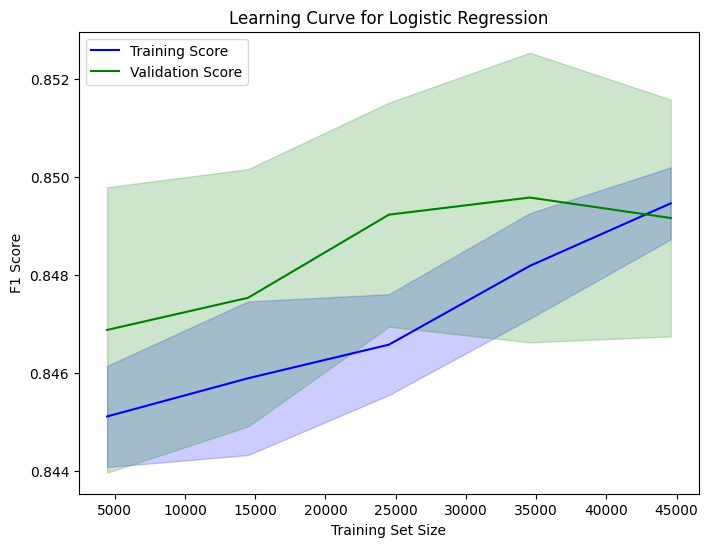

In [323]:

train_sizes, train_scores, val_scores = learning_curve(
    grid_log_reg.best_estimator_, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2
)
plt.plot(train_sizes, val_mean, label="Validation Score", color="green")
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2
)
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

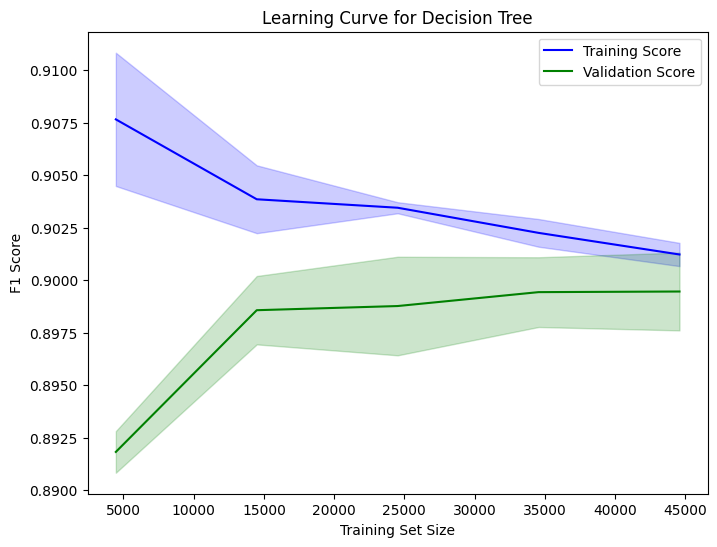

In [324]:
train_sizes, train_scores, val_scores = learning_curve(
    grid_dt.best_estimator_, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2
)
plt.plot(train_sizes, val_mean, label="Validation Score", color="green")
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2
)
plt.title("Learning Curve for Decision Tree")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

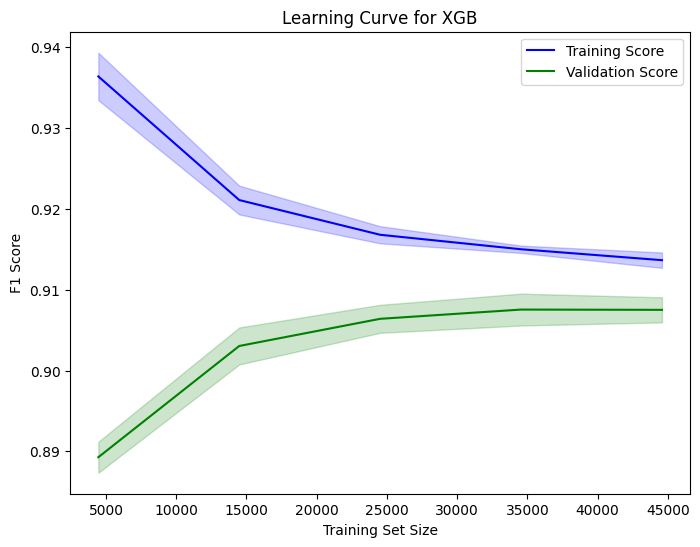

In [325]:
train_sizes, train_scores, val_scores = learning_curve(
    grid_xgb.best_estimator_, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2
)
plt.plot(train_sizes, val_mean, label="Validation Score", color="green")
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2
)
plt.title("Learning Curve for XGB")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

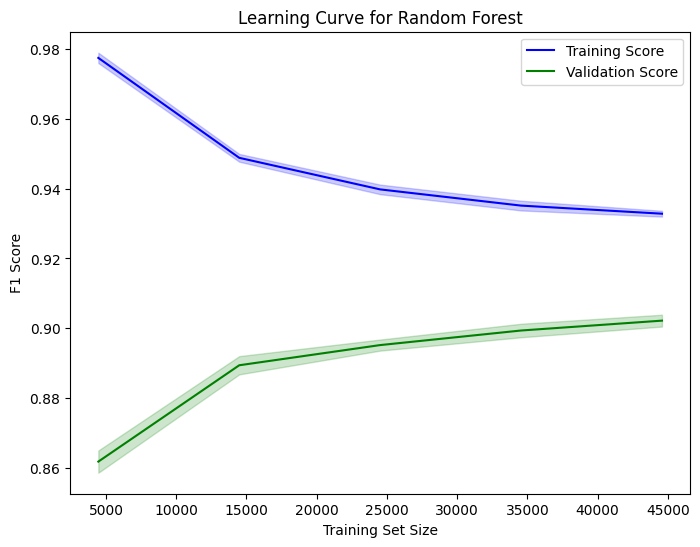

In [326]:
train_sizes, train_scores, val_scores = learning_curve(
    grid_rf.best_estimator_, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2
)
plt.plot(train_sizes, val_mean, label="Validation Score", color="green")
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2
)
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [327]:
xgb_results = pd.DataFrame(grid_xgb.cv_results_)
columns_to_keep = [
    col
    for col in xgb_results.columns
    if col.startswith("param_") or col == "mean_test_score"
]
xgb_results = xgb_results[columns_to_keep]

print(f"Training Time: {xgb_time} Seconds")
xgb_results

Training Time: 21.610609769821167 Seconds


,param_learning_rate,param_n_estimators,mean_test_score
0,0.01,50,0.895424
1,0.01,100,0.896472
2,0.01,200,0.897761
3,0.10,50,0.901933
4,0.10,100,0.904848
5,0.10,200,0.907112
6,0.20,50,0.905340
7,0.20,100,0.907036
8,0.20,200,0.907468


In [328]:
logreg_results = pd.DataFrame(grid_log_reg.cv_results_)
columns_to_keep = [
    col
    for col in logreg_results.columns
    if col.startswith("param_") or col == "mean_test_score"
]
logreg_results = logreg_results[columns_to_keep]
print(f"Training Time: {logreg_time}")
logreg_results

Training Time: 2.888700246810913


,param_C,param_penalty,mean_test_score
0,0.01,l1,NaN
1,0.01,l2,0.843784
2,0.10,l1,NaN
3,0.10,l2,0.841749
4,1.00,l1,NaN
5,1.00,l2,0.848642
6,10.00,l1,NaN
7,10.00,l2,0.849067


In [329]:
rf_results = pd.DataFrame(grid_rf.cv_results_)
columns_to_keep = [
    col
    for col in rf_results.columns
    if col.startswith("param_") or col == "mean_test_score"
]
rf_results = rf_results[columns_to_keep]
print(f"Training Time: {rf_time}")
rf_results

Training Time: 45.33838510513306


,param_max_depth,param_n_estimators,mean_test_score
0,10,50,0.900192
1,10,100,0.900079
2,10,200,0.900243
3,20,50,0.903152
4,20,100,0.902554
5,20,200,0.902508
6,None,50,0.871684
7,None,100,0.872744
8,None,200,0.873514


In [330]:
dt_results = pd.DataFrame(grid_dt.cv_results_)
columns_to_keep = [
    col
    for col in dt_results.columns
    if col.startswith("param_") or col == "mean_test_score"
]
dt_results = dt_results[columns_to_keep]
print(f"Training Time: {dt_time}")
dt_results

Training Time: 6.552701234817505


,param_criterion,param_max_depth,mean_test_score
0,gini,3,0.863948
1,gini,7,0.899061
2,gini,81,0.855425
3,gini,121,0.853783
4,entropy,3,0.861124
5,entropy,7,0.899423
6,entropy,81,0.862953
7,entropy,121,0.858231
